In [1]:
%pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

2024-01-11 16:15:07.545282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Load labels file
df = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/fog_aware_stats_new_labels.csv')
df = df[['photo', 'Label_new','Label_train']]
# Set image directory
img_dir = '/home/smmrrr/Fog_Imaging_Project/sta_221/all_surfline_photos/'

In [12]:
label_counts = df['Label_new'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
not_foggy    6981
foggy        1015
Name: Label_new, dtype: int64


In [14]:
label_counts

not_foggy    6981
foggy        1015
Name: Label_new, dtype: int64

In [13]:
display(df)

,photo,Label_new,Label_train
0,2022_07-04.0000_agatebeachor.jpg,not_foggy,0
1,2022_07-04.0000_otterrockor.jpg,not_foggy,0
2,2022_07-04.0700_agatebeachor.jpg,not_foggy,0
3,2022_07-04.0730_agatebeachor.jpg,not_foggy,0
4,2022_07-04.0730_otterrockor.jpg,not_foggy,0
...,...,...,...
7991,2023_09-30.1900_agatebeachor.jpg,not_foggy,0
7992,2023_09-30.1930_cannonbeach.jpg,not_foggy,0
7993,2023_09-30.2000_otterrockor.jpg,not_foggy,0
7994,2023_09-30.2030_otterrockor.jpg,not_foggy,0


In [16]:
label_counts.loc['not_foggy'] - label_counts.loc['foggy']

5966

In [21]:

# Number of data points to drop from the "non-foggy" class
num_to_drop = label_counts.loc['not_foggy'] - label_counts.loc['foggy']

# Check if the number to drop is greater than the count of "non-foggy" class
if num_to_drop > label_counts[0]:
    print("Warning: The specified number of data points to drop is greater than the count of 'foggy' class.")
else:
    # Randomly drop data points from the "non-foggy" class
    df_to_drop = df[df['Label_train'] == 0].sample(n=num_to_drop, random_state=42)
    df_filtered = df.drop(df_to_drop.index)

    # Display the resulting DataFrame
    print(df_filtered)
    print(label_counts)


                                  photo  Label_new  Label_train
4       2022_07-04.0730_otterrockor.jpg  not_foggy            0
9       2022_07-04.0830_otterrockor.jpg  not_foggy            0
16    2022_07-04.0930_lincolncityor.jpg  not_foggy            0
34      2022_07-04.1300_otterrockor.jpg  not_foggy            0
55      2022_07-04.1700_otterrockor.jpg  not_foggy            0
...                                 ...        ...          ...
7969    2023_09-29.2100_cannonbeach.jpg  not_foggy            0
7972  2023_09-30.1030_pacificcityor.jpg  not_foggy            0
7980  2023_09-30.1300_lincolncityor.jpg  not_foggy            0
7982    2023_09-30.1330_cannonbeach.jpg  not_foggy            0
7986   2023_09-30.1600_agatebeachor.jpg  not_foggy            0

[2030 rows x 3 columns]
not_foggy    6981
foggy        1015
Name: Label_new, dtype: int64


In [23]:
label_counts = df_filtered['Label_train'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
0    1015
1    1015
Name: Label_train, dtype: int64


In [28]:
# Load images and labels
data = []
labels = []

for index, row in df_filtered.iterrows():
    img_path = os.path.join(img_dir, row['photo'])
    try:
        img = load_img(img_path, target_size=(100, 100))  # Specify the target size of your images
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
    img_array = img_to_array(img)

    # Edge detection using Canny algorithm
    gray_image = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Stack the original image and edges as input
    img_with_edges = np.dstack([img_array, edges])
    
    data.append(img_with_edges)
    labels.append(row['Label_train'])

In [29]:
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Ensure labels are in the format 0 or 1 for binary classification
labels = labels.astype(int)

In [30]:
# Normalize pixel values to be between 0 and 1
data = data / 255.0

In [31]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [33]:
len(X_train)
len(X_test)

406

In [34]:
# Build CNN Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 4)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model with specified learning rate
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

2024-01-11 16:45:09.905755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [16]:
from keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
51/51 [==============================] - 12s 215ms/step - loss: 2.3477 - accuracy: 0.5277 - val_loss: 0.5777 - val_accuracy: 0.6675
Epoch 2/10
51/51 [==============================] - 10s 200ms/step - loss: 0.4085 - accuracy: 0.8208 - val_loss: 0.2346 - val_accuracy: 0.8867
Epoch 3/10
51/51 [==============================] - 10s 203ms/step - loss: 0.2316 - accuracy: 0.9089 - val_loss: 0.2016 - val_accuracy: 0.9261
Epoch 4/10
51/51 [==============================] - 10s 208ms/step - loss: 0.2207 - accuracy: 0.9113 - val_loss: 0.1913 - val_accuracy: 0.9261
Epoch 5/10
51/51 [==============================] - 10s 195ms/step - loss: 0.2005 - accuracy: 0.9181 - val_loss: 0.1737 - val_accuracy: 0.9310
Epoch 6/10
51/51 [==============================] - 10s 201ms/step - loss: 0.1823 - accuracy: 0.9280 - val_loss: 0.1807 - val_accuracy: 0.9335
Epoch 7/10
51/51 [==============================] - 11s 210ms/step - loss: 0.1490 - accuracy: 0.9390 - val_loss: 0.2238 - val_accuracy: 0.9261

In [21]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
216/216 [==============================] - 75s 337ms/step - loss: 0.6505 - accuracy: 0.8567 - val_loss: 0.2680 - val_accuracy: 0.8986
Epoch 2/10
216/216 [==============================] - 71s 327ms/step - loss: 0.2476 - accuracy: 0.9060 - val_loss: 0.2318 - val_accuracy: 0.9108
Epoch 3/10
216/216 [==============================] - 71s 327ms/step - loss: 0.2373 - accuracy: 0.9105 - val_loss: 0.2302 - val_accuracy: 0.9096
Epoch 4/10
216/216 [==============================] - 71s 328ms/step - loss: 0.2327 - accuracy: 0.9140 - val_loss: 0.2378 - val_accuracy: 0.9050
Epoch 5/10
216/216 [==============================] - 70s 323ms/step - loss: 0.2149 - accuracy: 0.9166 - val_loss: 0.2168 - val_accuracy: 0.9108
Epoch 6/10
216/216 [==============================] - 69s 321ms/step - loss: 0.2004 - accuracy: 0.9213 - val_loss: 0.2128 - val_accuracy: 0.9102
Epoch 7/10
216/216 [==============================] - 70s 325ms/step - loss: 0.1920 - accuracy: 0.9219 - val_loss: 0.2474 - val_ac

In [36]:
# Display additional metrics
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

13/13 [==============================] - 1s 43ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       210
           1       0.92      0.94      0.93       196

    accuracy                           0.93       406
   macro avg       0.93      0.93      0.93       406
weighted avg       0.93      0.93      0.93       406



In [37]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Creating the heatmap
    plt.figure(figsize=(10,7))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

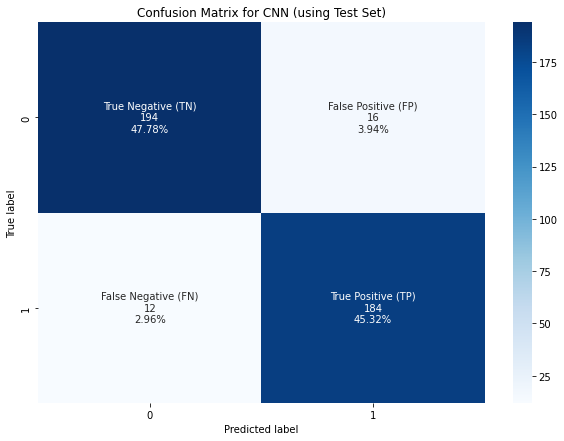

In [38]:
# Confusion Matrix
import seaborn as sns

plot_confusion_matrix(y_test, y_pred_binary, "CNN")


In [39]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [40]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

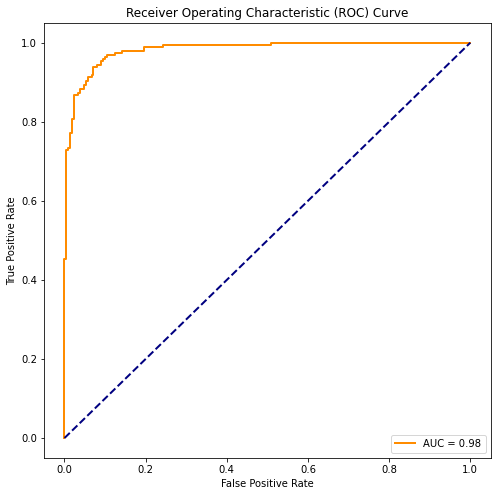

In [41]:
# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

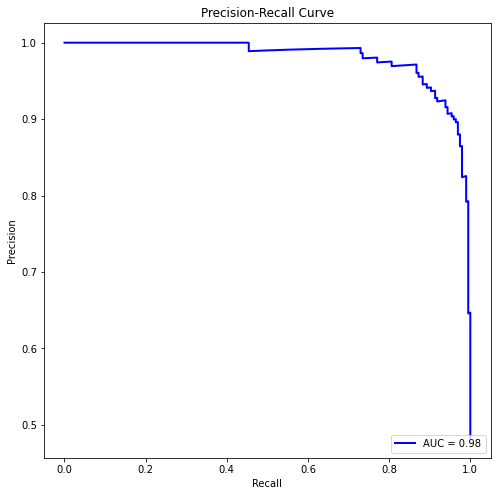

In [42]:
# Plot Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [43]:
links_and_labels_loop = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/unlabeled_photos_for_model.csv')
image_dir = '/home/smmrrr/surfline/'

# Load images and labels
data = []
labels = []

for index, row in links_and_labels_loop.iterrows():
    img_path = os.path.join(image_dir, row['photo'])
    img = load_img(img_path, target_size=(100, 100))  # Specify the target size of your images
    img_array = img_to_array(img)

    # Edge detection using Canny algorithm
    gray_image = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Stack the original image and edges as input
    img_with_edges = np.dstack([img_array, edges])
    
    data.append(img_with_edges)
    labels.append(row['photo'])

KeyboardInterrupt: 